In [1]:
from astropy.io import fits
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import redh3p as rhp
from PIL import Image

from lmfit import Model

import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

import os
spec_dir = os.path.abspath('./../../spec/')+'/'
figs_dir = os.path.abspath('./../../figures')
# import ipynbname
# nb_path = str(ipynbname.path())
# spec_dir = os.path.join(os.path.abspath(nb_path + '/../../../'), 'spec/')

fits_path_36 = spec_dir+'order36/jun02s*'
fits_path_35 = spec_dir+'order35/jun02s*'
fits_path_37 = spec_dir+'order37/jun02s*'
header_path = spec_dir+'jun02s*'

order36_data = rhp.read_file(path=fits_path_36)
order35_data = rhp.read_file(path=fits_path_35)
order37_data = rhp.read_file(path=fits_path_37)

int0 = 22
flat0 = 32
flat1 = 41
dark0 = 22
dark1 = 31

avg_flat_order36 = rhp.calc_avg(data=order36_data, start=flat0, stop=flat1, init=int0)
avg_dark_order36 = rhp.calc_avg(data=order36_data, start=dark0, stop=dark1, init=int0)

avg_flat_order35 = rhp.calc_avg(data=order35_data, start=flat0, stop=flat1, init=int0)
avg_dark_order35 = rhp.calc_avg(data=order35_data, start=dark0, stop=dark1, init=int0)

avg_flat_order37 = rhp.calc_avg(data=order37_data, start=flat0, stop=flat1, init=int0)
avg_dark_order37 = rhp.calc_avg(data=order37_data, start=dark0, stop=dark1, init=int0)

spec36_reducelist = []
spec35_reducelist = []
spec37_reducelist = []

sky_frame = [51,59,60,72,78,79,91,103]

for fn in range(60, 104):
    if fn in sky_frame:
        continue
    else:
        skyframe36 = rhp.scale_sky_frame(data=order36_data, datfn=fn, skyfn=sky_frame, init=int0, path=header_path)
        skyframe35 = rhp.scale_sky_frame(data=order35_data, datfn=fn, skyfn=sky_frame, init=int0, path=header_path)
        skyframe37 = rhp.scale_sky_frame(data=order37_data, datfn=fn, skyfn=sky_frame, init=int0, path=header_path)
        
        reduce_spec36 = (order36_data[fn-int0] - skyframe36) / (avg_flat_order36 - avg_dark_order36)
        reduce_spec36[reduce_spec36<0] = 0
        
        reduce_spec35 = (order35_data[fn-int0] - skyframe35) / (avg_flat_order35 - avg_dark_order35)
        reduce_spec35[reduce_spec35<0] = 0
#         reduce_spec35 = np.delete(reduce_spec35, np.s_[:8], 0)
        
        reduce_spec37 = (order37_data[fn-int0] - skyframe37) / (avg_flat_order37 - avg_dark_order37)
        reduce_spec37[reduce_spec37<0] = 0
#         reduce_spec37 = np.vstack((reduce_spec37, np.zeros((7, 1024))))
    
        spec36_reducelist.append(reduce_spec36)
        spec35_reducelist.append(reduce_spec35)
        spec37_reducelist.append(reduce_spec37)
        
spec36_reduced = np.array(spec36_reducelist)
spec35_reduced = np.array(spec35_reducelist)
spec37_reduced = np.array(spec37_reducelist)

waverange36 = fits.open(spec_dir + 'order36/' + 'waverange.fits', ignore_missing_end=True)[0].data
waverange35 = fits.open(spec_dir + 'order35/' + 'waverange.fits', ignore_missing_end=True)[0].data
waverange37 = fits.open(spec_dir + 'order37/' + 'waverange.fits', ignore_missing_end=True)[0].data

R36 = 73194.84858495607
R35 = 73234.23454151815
R37 = 72736.04543958924
R = np.mean((R36,R35,R37))

# star flux calibration
modeA36 = order36_data[104-int0] + order36_data[107-int0] +\
        order36_data[108-int0] + order36_data[111-int0]
modeB36 = order36_data[105-int0] + order36_data[106-int0] +\
        order36_data[109-int0] + order36_data[110-int0]

modeA35 = order35_data[104-int0] + order35_data[107-int0] +\
        order35_data[108-int0] + order35_data[111-int0]
modeB35 = order35_data[105-int0] + order35_data[106-int0] +\
        order35_data[109-int0] + order35_data[110-int0]

modeA37 = order37_data[104-int0] + order37_data[107-int0] +\
        order37_data[108-int0] + order37_data[111-int0]
modeB37 = order37_data[105-int0] + order37_data[106-int0] +\
        order37_data[109-int0] + order37_data[110-int0]

exp_star = 20

modeAB36 = ((modeA36 - modeB36)/4)/(avg_flat_order36 - avg_dark_order36)/exp_star

modeAB35 = ((modeA35 - modeB35)/4)/(avg_flat_order35 - avg_dark_order35)/exp_star

modeAB37 = ((modeA37 - modeB37)/4)/(avg_flat_order37 - avg_dark_order37)/exp_star

flux36_model = Model(rhp.gaussian_fit)
flux35_model = Model(rhp.gaussian_fit)
flux37_model = Model(rhp.gaussian_fit)

flux36_params = flux36_model.make_params()
flux36_params.add('a0', value=0.003, min=0, max=0.01)
flux36_params.add('a1', value=36)
flux36_params.add('a2', value=2, min=0.5, max=5)
flux36_params.add('a3', value=0)
flux36_params.add('a4', value=0)
flux36_params.add('a5', value=0)

flux35_params = flux35_model.make_params()
flux35_params.add('a0', value=0.003, min=0, max=0.01)
flux35_params.add('a1', value=42)
flux35_params.add('a2', value=2, min=0.5, max=5)
flux35_params.add('a3', value=0)
flux35_params.add('a4', value=0)
flux35_params.add('a5', value=0)

flux37_params = flux37_model.make_params()
flux37_params.add('a0', value=0.003, min=0, max=0.01)
flux37_params.add('a1', value=38)
flux37_params.add('a2', value=2, min=0.5, max=5)
flux37_params.add('a3', value=0)
flux37_params.add('a4', value=0)
flux37_params.add('a5', value=0)

lower = 0
upper = 1024

star36_a0 = np.zeros(np.size(modeAB36,1))
star36_a2 = np.zeros(np.size(modeAB36,1))

star35_a0 = np.zeros(np.size(modeAB35,1))
star35_a2 = np.zeros(np.size(modeAB35,1))

star37_a0 = np.zeros(np.size(modeAB37,1))
star37_a2 = np.zeros(np.size(modeAB37,1))

spat_ax36 = np.linspace(0, modeAB36.shape[0]-1, modeAB36.shape[0])
spat_ax35 = np.linspace(0, modeAB35.shape[0]-1, modeAB35.shape[0])
spat_ax37 = np.linspace(0, modeAB37.shape[0]-1, modeAB37.shape[0])

for i in range(lower, upper):
    try:
        flux36_fit_result = flux36_model.fit(modeAB36.T[i], flux36_params, x=spat_ax36)
    except ValueError:
        print('ValueError occured at i=' + str(i) + ' order36')
        
    try:
        flux35_fit_result = flux35_model.fit(modeAB35.T[i], flux35_params, x=spat_ax35)
    except ValueError:
        print('ValueError occured at i=' + str(i) + ' order35')
        
    try:
        flux37_fit_result = flux37_model.fit(modeAB37.T[i], flux37_params, x=spat_ax37)
    except ValueError:
        print('ValueError occured at i=' + str(i) + ' order37')
        
    star36_a0[i] = flux36_fit_result.params['a0'].value
    star36_a2[i] = flux36_fit_result.params['a2'].value
    
    star35_a0[i] = flux35_fit_result.params['a0'].value
    star35_a2[i] = flux35_fit_result.params['a2'].value
    
    star37_a0[i] = flux37_fit_result.params['a0'].value
    star37_a2[i] = flux37_fit_result.params['a2'].value
    
# compute calibration spectra
lambda_aw = 2.2 # mu m
hc_kb = 14388 # mu m K
T = 10000 # K

F_alpha_lyrae = 4.07e-10 # alpha Lyrae in atmospheric window 2.2 mu m
m_lambda = 6.749 # Kmag HD 131885
F_a0 = F_alpha_lyrae * 10**(-0.4*m_lambda)

Fbb36 = F_a0 * ((lambda_aw/waverange36)**5) * ((np.exp(hc_kb/(lambda_aw*T)) - 1)/(np.exp(hc_kb/(waverange36*T)) - 1))

Fbb35 = F_a0 * ((lambda_aw/waverange35)**5) * ((np.exp(hc_kb/(lambda_aw*T)) - 1)/(np.exp(hc_kb/(waverange35*T)) - 1))

Fbb37 = F_a0 * ((lambda_aw/waverange37)**5) * ((np.exp(hc_kb/(lambda_aw*T)) - 1)/(np.exp(hc_kb/(waverange37*T)) - 1))

star36_fwhm = star36_a2*(np.sqrt(2*np.log(2))*2)
Fobs36 = star36_a0 * star36_fwhm

star35_fwhm = star35_a2*(np.sqrt(2*np.log(2))*2)
Fobs35 = star35_a0 * star35_fwhm

star37_fwhm = star37_a2*(np.sqrt(2*np.log(2))*2)
Fobs37 = star37_a0 * star37_fwhm

Fc36 = Fbb36/Fobs36

Fc35 = Fbb35/Fobs35

Fc37 = Fbb37/Fobs37

width36 = spec36_reduced.shape[1]
length36 = spec36_reduced.shape[2]

width35 = spec35_reduced.shape[1]
length35 = spec35_reduced.shape[2]

width37 = spec37_reduced.shape[1]
length37 = spec37_reduced.shape[2]

slit_area36 = 0.288 * width36 * 2.908e-5 * length36

slit_area35 = 0.288 * width35 * 2.999e-5 * length35

slit_area37 = 0.288 * width37 * 2.859e-5 * length37

exp_spec = 60

fjc36_list = []
fjc35_list = []
fjc37_list = []

for i in range(np.size(spec36_reduced, axis=0)):
    fjc36_list.append(spec36_reduced[i] / exp_spec * Fc36 * 4.2535e10 / slit_area36)
    fjc35_list.append(spec35_reduced[i] / exp_spec * Fc35 * 4.2535e10 / slit_area35)
    fjc37_list.append(spec37_reduced[i] / exp_spec * Fc37 * 4.2535e10 / slit_area37)
    
fjc36 = np.array(fjc36_list)
fjc35 = np.array(fjc35_list)
fjc37 = np.array(fjc37_list)


# rescale spatial axis
RA_modeA = 224.23866
RA_modeB = 224.24037
DEC_modeA = -26.28654
DEC_modeB = -26.28358

arcsec_diff_star = np.sqrt(((RA_modeA-RA_modeB)*3600)**2 + ((DEC_modeA-DEC_modeB)*3600)**2)
arcsec_per_pix_new = 0.1

pix_diff_star36 = np.where(modeAB36.T[200]==np.min(modeAB36.T[200]))[0][0] -\
    np.where(modeAB36.T[200]==np.max(modeAB36.T[200]))[0][0]

pix_diff_star35 = np.where(modeAB35.T[200]==np.min(modeAB35.T[200]))[0][0] -\
    np.where(modeAB35.T[200]==np.max(modeAB35.T[200]))[0][0]

pix_diff_star37 = np.where(modeAB37.T[200]==np.min(modeAB37.T[200]))[0][0] -\
    np.where(modeAB37.T[200]==np.max(modeAB37.T[200]))[0][0]

zoom_fac36 = (arcsec_diff_star/arcsec_per_pix_new)/pix_diff_star36
zoom_fac35 = (arcsec_diff_star/arcsec_per_pix_new)/pix_diff_star35
zoom_fac37 = (arcsec_diff_star/arcsec_per_pix_new)/pix_diff_star37

fjc36_rs = scipy.ndimage.zoom(fjc36, [1,zoom_fac36,1], mode='nearest')
fjc35_rs = scipy.ndimage.zoom(fjc35, [1,zoom_fac35,1], mode='nearest')
fjc37_rs = scipy.ndimage.zoom(fjc37, [1,zoom_fac37,1], mode='nearest')

fjc36_rs = np.delete(fjc36_rs, np.s_[260:], 1)
fjc35_rs = np.delete(fjc35_rs, np.s_[:14], 1)
fjc35_rs = np.delete(fjc35_rs, np.s_[260:], 1)

Text(2.20299, 0.005, '12')

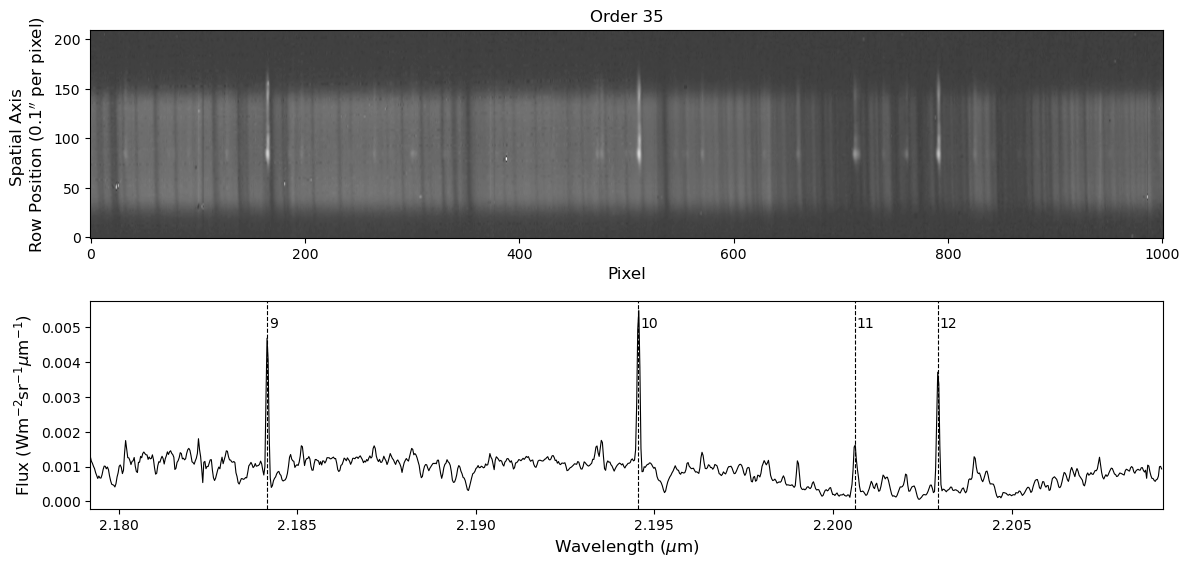

In [2]:
fig = plt.figure(figsize=(12,8), tight_layout=True)

fig.add_subplot(311)
plt.imshow(fjc35_rs[1][30:240,:1001],
#            extent=[waverange35[0],waverange35[1001],30,240],
           aspect='auto',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=0.4), 
           origin='lower')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.xlabel('Pixel', fontsize=12)
plt.title('Order 35', fontsize=12)

fig.add_subplot(312)
plt.plot(waverange35[:1001], fjc35_rs[1][30:240,:1001][90],'k', lw=0.8)
plt.xlim(waverange35[0], waverange35[1001])
plt.ylabel('Flux (Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$)', fontsize=12)
plt.xlabel('Wavelength ($\mu$m)', fontsize=12)

# plt.xlim(2.2025,2.2035)
plt.axvline(2.18416, color='k', ls='--', lw=0.8)
plt.axvline(2.19455, color='k', ls='--', lw=0.8)
plt.axvline(2.20061, color='k', ls='--', lw=0.8)
plt.axvline(2.20294, color='k', ls='--', lw=0.8)

plt.text(2.18421,0.005, '9')
plt.text(2.1946,0.005, '10')
plt.text(2.20066,0.005, '11')
plt.text(2.20299,0.005, '12')

Text(2.13433, 0.0085, '8')

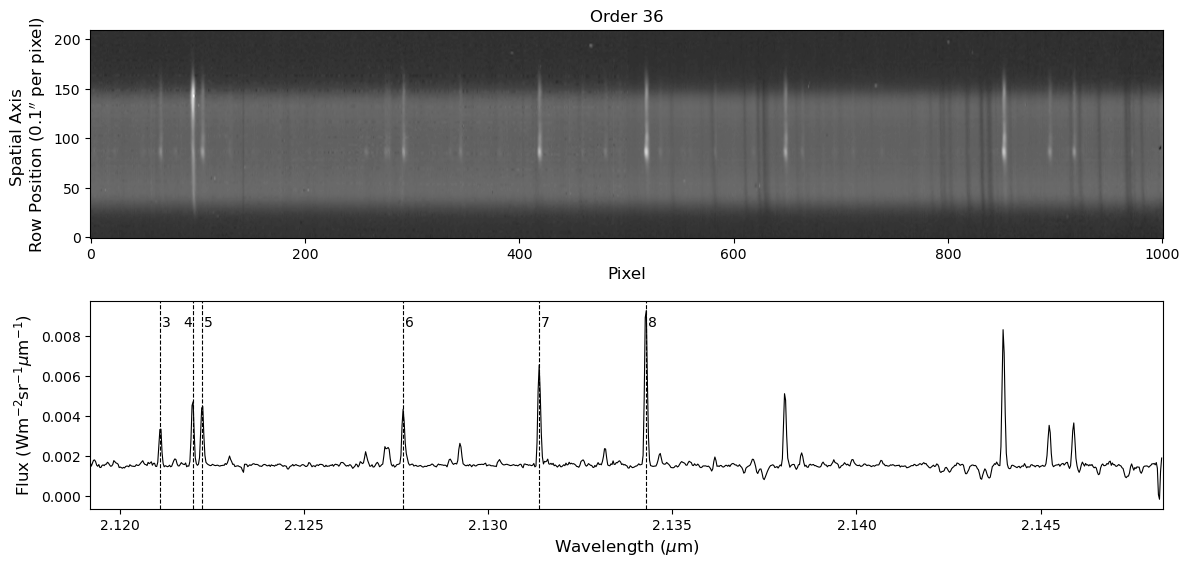

In [3]:
fig = plt.figure(figsize=(12,8), tight_layout=True)

fig.add_subplot(311)
plt.imshow(fjc36_rs[1][30:240,:1001],
#            extent=[waverange36[0],waverange36[1001],30,240],
           aspect='auto',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=0.4), 
           origin='lower')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.xlabel('Pixel', fontsize=12)
plt.title('Order 36', fontsize=12)

fig.add_subplot(312)
plt.plot(waverange36[:1001], fjc36_rs[1][30:240,:1001][90],'k', lw=0.8)
plt.xlim(waverange36[0], waverange36[1001])
plt.ylabel('Flux (Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$)', fontsize=12)
plt.xlabel('Wavelength ($\mu$m)', fontsize=12)

plt.axvline(2.1211, color='k', ls='--', lw=0.8)
plt.axvline(2.12198, color='k', ls='--', lw=0.8)
plt.axvline(2.122245, color='k', ls='--', lw=0.8)
plt.axvline(2.1277, color='k', ls='--', lw=0.8)
plt.axvline(2.13139, color='k', ls='--', lw=0.8)
plt.axvline(2.13428, color='k', ls='--', lw=0.8)

plt.text(2.12115,0.0085, '3')
plt.text(2.12173,0.0085, '4')
plt.text(2.122295,0.0085, '5')
plt.text(2.12775,0.0085, '6')
plt.text(2.13144,0.0085, '7')
plt.text(2.13433,0.0085, '8')

Text(2.07635, 0.025, '2')

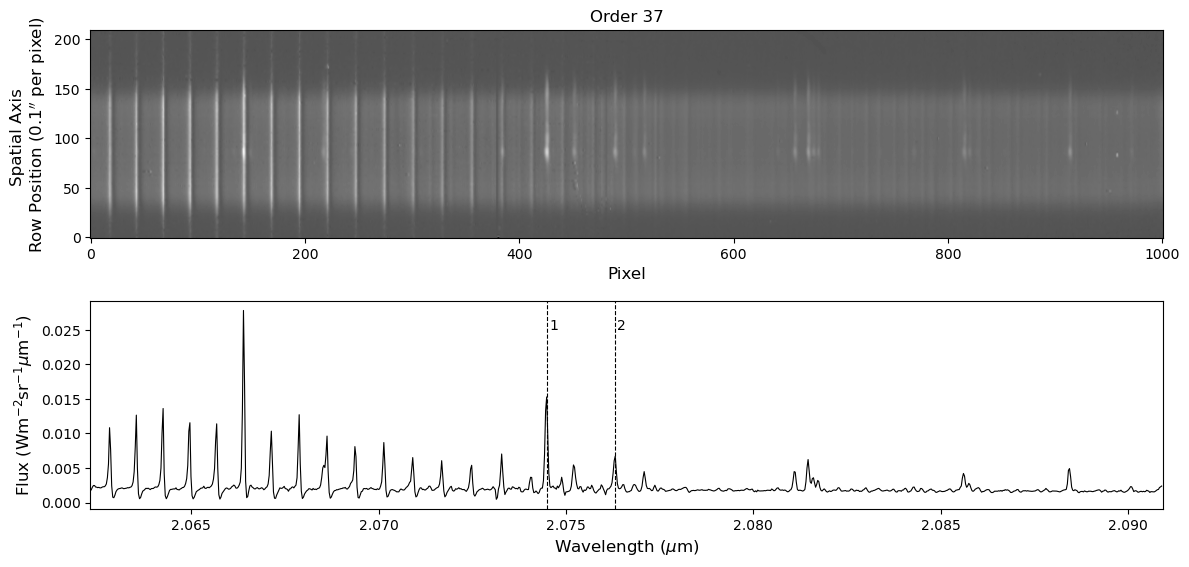

In [4]:
fig = plt.figure(figsize=(12,8), tight_layout=True)

fig.add_subplot(311)
plt.imshow(fjc37_rs[1][30:240,:1001],
#            extent=[waverange37[0],waverange37[1001],30,240],
           aspect='auto',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=0.4), 
           origin='lower')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.xlabel('Pixel', fontsize=12)
plt.title('Order 37', fontsize=12)

fig.add_subplot(312)
plt.plot(waverange37[:1001], fjc37_rs[1][30:240,:1001][90],'k', lw=0.8)
plt.xlim(waverange37[0], waverange37[1001])
# plt.xlim(2.0744,2.0746)
plt.ylabel('Flux (Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$)', fontsize=12)
plt.xlabel('Wavelength ($\mu$m)', fontsize=12)

plt.axvline(2.0745, color='k', ls='--', lw=0.8)
plt.axvline(2.0763, color='k', ls='--', lw=0.8)

plt.text(2.07455,0.025, '1')
plt.text(2.07635,0.025, '2')

(2.1192026138305664, 2.1483116149902344)

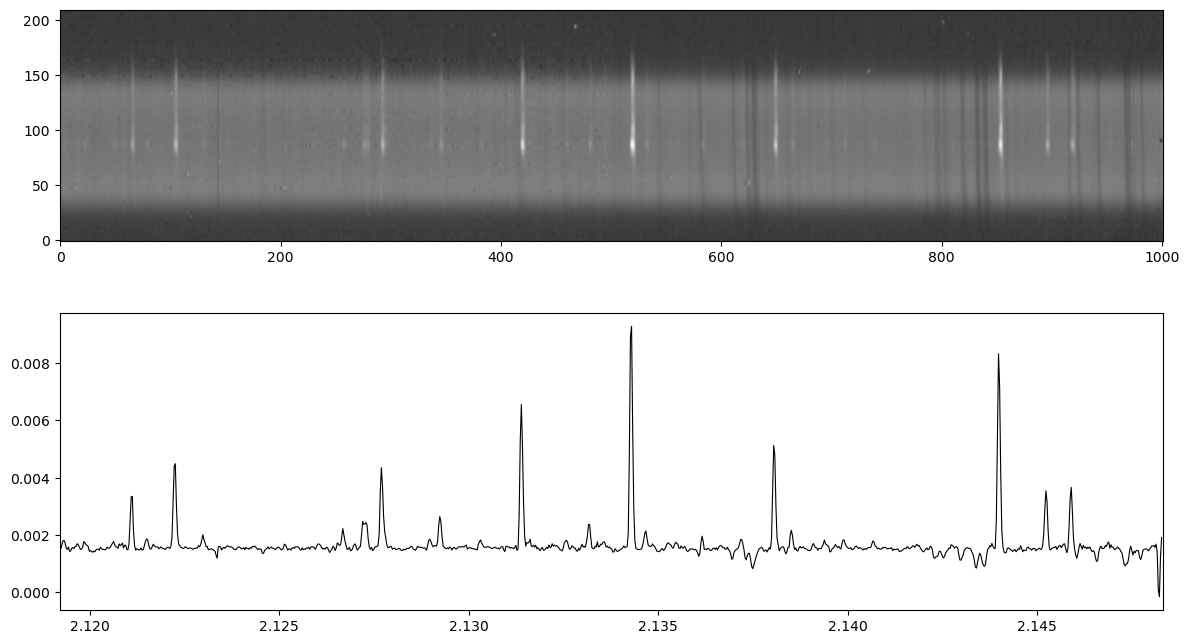

In [14]:
# a = 100
# b = 115

# wav = waverange36[:1001]
# spe = fjc36_rs[1][30:240,a:b]

spec36_h3p = np.concatenate((fjc36_rs[1][30:240,:89],fjc36_rs[1][30:240,189:201], fjc36_rs[1][30:240,101:1001]), axis=1)
wave36_h3p = np.concatenate((waverange36[:89], waverange36[189:201], waverange36[101:1001]))

fig = plt.figure(figsize=(12,10), tight_layout=True)

# fig.add_subplot(311)
# plt.imshow(spe,
# #            extent=[waverange36[0],waverange36[1001],30,240],
#            aspect='equal',
#            cmap='gist_gray', 
#            norm=colors.PowerNorm(gamma=0.4), 
#            origin='lower')
# plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
# plt.xlabel('Pixel', fontsize=12)
# plt.title('Order 36', fontsize=12)

fig.add_subplot(311)
plt.imshow(spec36_h3p,
#            extent=[waverange36[0],waverange36[1001],30,240],
           aspect='equal',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=0.4), 
           origin='lower')

fig.add_subplot(312)
plt.plot(waverange36[:1001], spec36_h3p[90],'k', lw=0.8)
plt.xlim(waverange36[0], waverange36[1001])

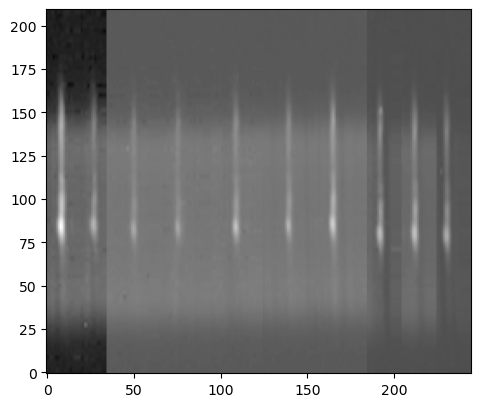

In [15]:
spec35 = fjc35_rs[1][30:240,:1001]
spec36 = spec36_h3p
spec37 = fjc37_rs[1][30:240,:1001]


order35_s1_off = 12.290742537910269 - 7.155130529216581
order35_s2_off = 11.715182831885945 - 7.09831071322741
order35_s3_off = 11.28956063826212 - 5.60760044988149

order35_s1a = 153
order35_s1b = 173
order35_s2a = 500
order35_s2b = 520
order35_s3a = 780
order35_s3b = 800

order35_s1 = scipy.ndimage.shift(spec35[:,order35_s1a:order35_s1b], -order35_s1_off, order=3, mode='nearest')
order35_s2 = scipy.ndimage.shift(spec35[:,order35_s2a:order35_s2b], -order35_s2_off, order=3, mode='nearest')
order35_s3 = scipy.ndimage.shift(spec35[:,order35_s3a:order35_s3b], -order35_s3_off, order=3, mode='nearest')

spec35_to_fit = np.concatenate((order35_s1, order35_s2, order35_s3,), axis=1)
wave35_to_fit = np.concatenate((waverange35[order35_s1a:order35_s1b], 
                                waverange35[order35_s2a:order35_s2b], 
                                waverange35[order35_s3a:order35_s3b],))

order36_s1_off = 19.508939722898322 - 14.995132257088052
order36_s2_off = 32.19211523278931 - 28.50777176636832
order36_s3_off = 39.03275085626387 - 35.93644961828873
order36_s4_off = 28.376016716143557 - 26.345579923793743
order36_s5_off = 32.285704267276024 - 30.820808697365763

order36_s1a = 85
order36_s1b = 115
order36_s2a = 278
order36_s2b = 308
order36_s3a = 402
order36_s3b = 432
order36_s4a = 632
order36_s4b = 662
order36_s5a = 841
order36_s5b = 871

order36_s1 = scipy.ndimage.shift(spec36[:,order36_s1a:order36_s1b], -order36_s1_off, order=3, mode='nearest')
order36_s2 = scipy.ndimage.shift(spec36[:,order36_s2a:order36_s2b], -order36_s2_off, order=3, mode='nearest')
order36_s3 = scipy.ndimage.shift(spec36[:,order36_s3a:order36_s3b], -order36_s3_off, order=3, mode='nearest')
order36_s4 = scipy.ndimage.shift(spec36[:,order36_s4a:order36_s4b], -order36_s4_off, order=3, mode='nearest')
order36_s5 = scipy.ndimage.shift(spec36[:,order36_s5a:order36_s5b], -order36_s5_off, order=3, mode='nearest')

spec36_to_fit = np.concatenate((order36_s1,order36_s2,order36_s3,order36_s4,order36_s5), axis=1)
wave36_to_fit = np.concatenate((waverange36[order36_s1a:order36_s1b],
                                waverange36[order36_s2a:order36_s2b],
                                waverange36[order36_s3a:order36_s3b],
                                waverange36[order36_s4a:order36_s4b],
                                waverange36[order36_s5a:order36_s5b],))

order37_s1_off = 10.726523847017612 - 8.272614883168751
order37_s2_off = 8.570777141472702 - 6.927853944164028

order37_s1a = 415
order37_s1b = 435
order37_s2a = 481
order37_s2b = 496

order37_s1 = scipy.ndimage.shift(spec37[:,order37_s1a:order37_s1b], -order37_s1_off, order=3, mode='nearest')
order37_s2 = scipy.ndimage.shift(spec37[:,order37_s2a:order37_s2b], -order37_s2_off, order=3, mode='nearest')


spec37_to_fit = np.concatenate((order37_s1, order37_s2,), axis=1)
wave37_to_fit = np.concatenate((waverange37[order37_s1a:order37_s1b],
                                waverange37[order37_s2a:order37_s2b],))

spec37_to_fit = spec37_to_fit - np.median(spec37)
# spec36_to_fit = spec36_to_fit - np.median(spec36)
spec35_to_fit = spec35_to_fit - np.median(spec35)

spec_to_fit = np.concatenate((spec37_to_fit, spec36_to_fit, spec35_to_fit,), axis=1)
wave_to_fit = np.concatenate((wave37_to_fit, wave36_to_fit, wave35_to_fit))

fig = plt.figure(figsize=(12,12), tight_layout=True)

# fig.add_subplot(311)
# plt.imshow(spe,
# #            extent=[waverange36[0],waverange36[1001],30,240],
#            aspect='equal',
#            cmap='gist_gray', 
#            norm=colors.PowerNorm(gamma=0.4), 
#            origin='lower')
# plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
# plt.xlabel('Pixel', fontsize=12)
# plt.title('Order 36', fontorder36_size=12)
# plt.colorbar()

fig.add_subplot(312)
plt.imshow(spec_to_fit,
#            extent=[waverange36[0],waverange36[1001],30,240],
           aspect='equal',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=0.4), 
           origin='lower')
# plt.colorbar()

# fig.add_order36_subplot(313)
# plt.plot(waverange36[a:b], fjc36_rorder36_s[1][30:240,a:b][90], 'k', lw=0.8)
# # plt.plot(waverange36[a:b], order36_s1[90], 'r', lw=0.8)
# plt.xlim(waverange36[a], waverange36[b])
# plt.ylabel('Flux (Wm$^{-2}$order36_sr$^{-1}$$\mu$m$^{-1}$)', fontorder36_size=12)
# plt.xlabel('Wavelength ($\mu$m)', fontorder36_size=12)

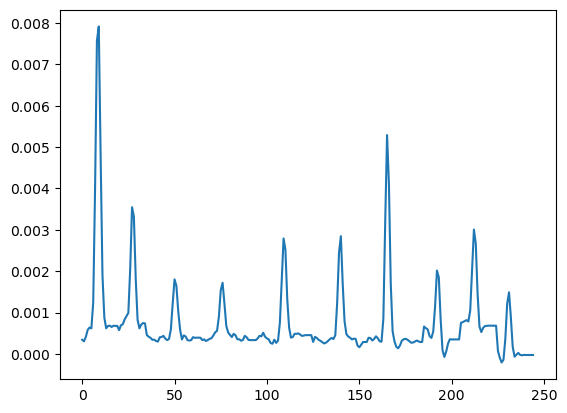

In [9]:
plt.plot(spec_to_fit[100])

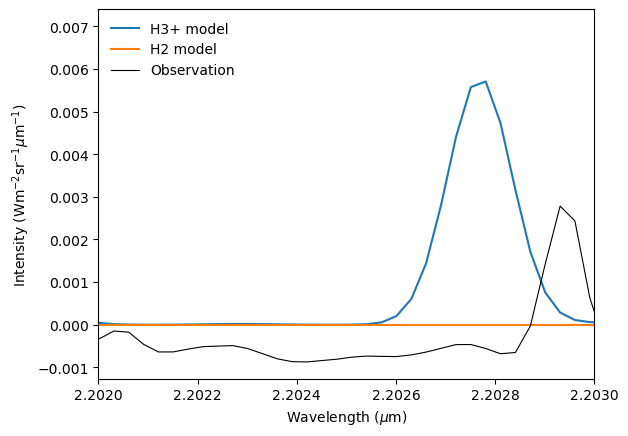

In [105]:
import h3ppy

# Create the H3+ object
h3p = h3ppy.h3p()
h2 = h3ppy.h2()

# Define a wavelength range, e.g. typical of an observation of the H3+ Q branch
# Specify the start and end wavelengths, and the number of wavelength elements
# wave = h3p.wavegen(3.94, 4.03, 1024)
wave = waverange35[:1001]
spec = fjc35_rs[1][30:240,:1001][90]
# spec = newspec[90]


noise = np.median(spec)

spec = spec - noise

# Create a H3+ model spectrum for a set of physical parameters 
# Spectral resolution R = 1200, T = 1000, N = 1e14
# This is the minimum set of parameters required for generating a model
model = h3p.model(density = 7e16, temperature = 950, R = R36/3, wavelength = wave)
model2 = h2.model(density = 3e25, temperature = 950, R = R36/3, wavelength = wave)

# newspec = scipy.ndimage.shift(spec, -s4_off, order=3, mode='nearest')

# Plot the model
fig, ax = plt.subplots()
ax.plot(wave, model, label = 'H3+ model')
ax.plot(wave, model2, label ='H2 model')
ax.plot(wave, spec,'k', lw=0.8, label = 'Observation')
# ax.plot(wave, newspec, label = 'shifted spec')
# ax.set_xlim(wave[0], wave[-1])
ax.set_xlim(2.202,2.203)
# ax.set_xlim(2.130,2.135)
# Automagically set the labels 
ax.set_xlabel(h3p.xlabel())
ax.set_ylabel(h3p.ylabel())
# plt.savefig('example_model.png')
# plt.close() 
ax.legend(frameon = False)

Text(0.5, 0, 'Pixel')

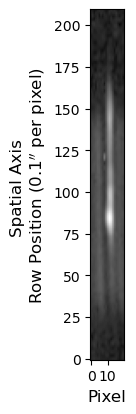

In [94]:
a = 780
b = 800

wav = waverange35[:1001]
spe = fjc35_rs[1][30:240,a:b]

fig = plt.figure(figsize=(12,12), tight_layout=True)

fig.add_subplot(311)
plt.imshow(spe,
#            extent=[waverange36[0],waverange36[1001],30,240],
           aspect='equal',
           cmap='gist_gray', 
           norm=colors.PowerNorm(gamma=0.4), 
           origin='lower')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)', fontsize=12)
plt.xlabel('Pixel', fontsize=12)

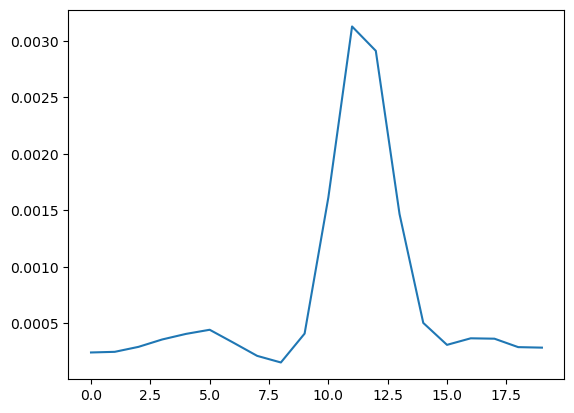

In [95]:
plt.plot(spe[100])

[[Model]]
    Model(gaussian_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 57
    # data points      = 20
    # variables        = 6
    chi-square         = 6.2889e-10
    reduced chi-square = 4.4921e-11
    Akaike info crit   = -471.655846
    Bayesian info crit = -465.681452
[[Variables]]
    a0:  0.00576566 +/- 5.8585e-06 (0.10%) (init = 0.02)
    a1:  5.60760045 +/- 0.00224331 (0.04%) (init = 7)
    a2:  2.10211636 +/- 0.00189398 (0.09%) (init = 1)
    a3:  9.3656e-06 +/- 6.7775e-06 (72.37%) (init = 0)
    a4:  6.8006e-06 +/- 1.2287e-06 (18.07%) (init = 0)
    a5: -3.2727e-07 +/- 6.5332e-08 (19.96%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -0.936
    C(a2, a3) = -0.645
    C(a3, a4) = -0.554
    C(a1, a4) = -0.534
    C(a1, a3) =  0.483
    C(a0, a3) = -0.424
    C(a0, a5) =  0.421
    C(a1, a5) =  0.413
    C(a0, a2) =  0.256
    C(a3, a5) =  0.249
    C(a2, a5) =  0.241
    C(a0, a4) = -0.225
    C(a1, 

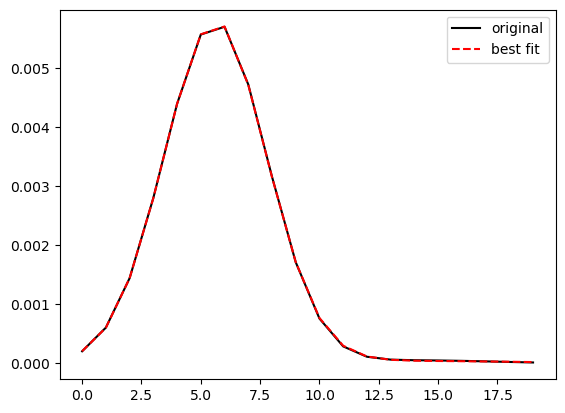

In [96]:
y = model[a:b]
x = np.linspace(0,len(y)-1,len(y))

# create lmfit model with defined gaussian
m_model = Model(rhp.gaussian_fit)

# create parameters and add initial guess
m_params = m_model.make_params()
m_params.add('a0', value=0.02)
m_params.add('a1', value=7)
m_params.add('a2', value=1)
m_params.add('a3', value=0)
m_params.add('a4', value=0)
m_params.add('a5', value=0)

try:
    m_result = m_model.fit(y, m_params, x=x)
except:
    pass

print(m_result.fit_report())

plt.figure()
plt.plot(x, y, 'k', label='original')
plt.plot(x, m_result.best_fit, 'r--', label='best fit')
plt.legend()

print(m_result.params['a1'].value)

[[Model]]
    Model(gaussian_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 20
    # variables        = 6
    chi-square         = 1.1308e-07
    reduced chi-square = 8.0771e-09
    Akaike info crit   = -367.818173
    Bayesian info crit = -361.843780
[[Variables]]
    a0:  0.00354795 +/- 8.3913e-05 (2.37%) (init = 0.02)
    a1:  11.2895606 +/- 0.02954797 (0.26%) (init = 12)
    a2:  1.40157873 +/- 0.02787840 (1.99%) (init = 1)
    a3: -6.6687e-04 +/- 5.9119e-05 (8.87%) (init = 0)
    a4:  1.8703e-05 +/- 1.7520e-05 (93.67%) (init = 0)
    a5: -9.7262e-07 +/- 8.7343e-07 (89.80%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -0.979
    C(a3, a4) = -0.836
    C(a3, a5) =  0.743
    C(a2, a4) = -0.448
    C(a2, a5) =  0.432
    C(a0, a4) = -0.362
    C(a0, a5) =  0.353
    C(a2, a3) =  0.254
    C(a0, a3) =  0.221
    C(a0, a2) = -0.209
11.28956063826212


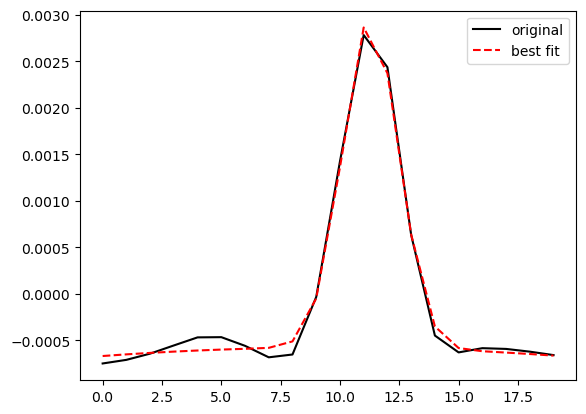

In [97]:
yy = spec[a:b]
xx = np.linspace(0,len(yy)-1,len(yy))


# create lmfit model with defined gaussian
s_model = Model(rhp.gaussian_fit)

# create parameters and add initial guess
s_params = s_model.make_params()
s_params.add('a0', value=0.02)
s_params.add('a1', value=12)
s_params.add('a2', value=1)
s_params.add('a3', value=0)
s_params.add('a4', value=0)
s_params.add('a5', value=0)

try:
    s_result = s_model.fit(yy, s_params, x=xx)
except:
    pass

print(s_result.fit_report())

plt.figure()
plt.plot(xx, yy, 'k', label='original')
plt.plot(xx, s_result.best_fit, 'r--', label='best fit')
plt.legend()

print(s_result.params['a1'].value)

In [98]:
11.28956063826212 - 5.60760044988149

5.68196018838063

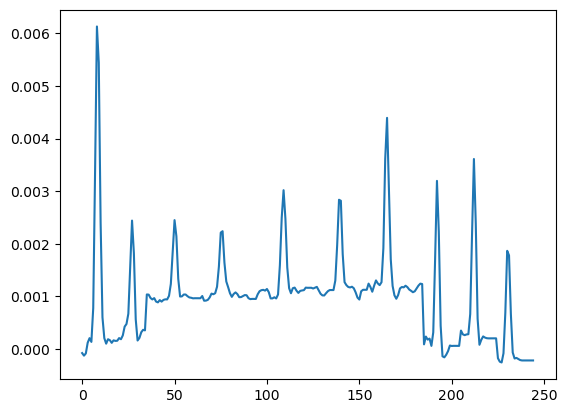

In [34]:
plt.plot(spec_to_fit[140])

[h3ppy]  Spectrum parameters:
         Temperature    = 764.5 +/- 35.7 [K]
         Column density = 9.95E+16 +/-  3.94E+16 [m-2]
         ------------------------------
         background_0 = 3.56E-04 +/- 2.44E-05
         offset_0 = 8.94E-06 +/- 1.05E-06
         sigma_0 = 3.51E-05 +/- 1.10E-06



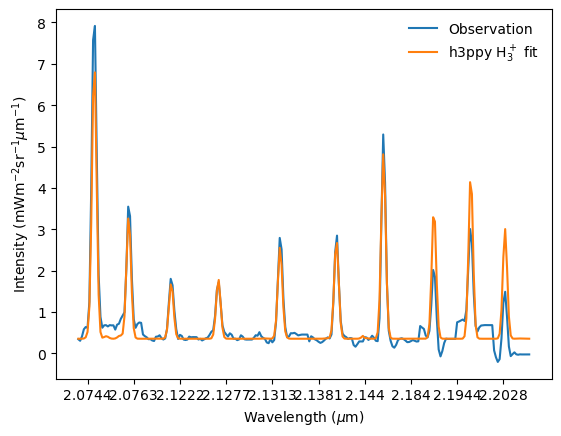

In [109]:
# Create the H3+ object
h3p = h3ppy.h3p()
h2 = h3ppy.h2()

# Define a wavelength range, e.g. typical of an observation of the H3+ Q branch
# Specify the start and end wavelengths, and the number of wavelength elements
wave = wave_to_fit
spec = spec_to_fit[100]

# Create a H3+ model spectrum for a set of physical parameters 
# Spectral resolution R = 1200, T = 1000, N = 1e14
# This is the minimum set of parameters required for generating a model
model = h3p.model(density = 3e16, temperature = 1000, R = 25000, wavelength = wave)
model2 = h2.model(density = 3e25, temperature = 1000, R = 25000, wavelength = wave)

# noise = np.median(spec)
# newspec = spec - noise

# Set the wavelength and the data
h3p.set(wavelength = wave, data = spec, R = 25000, density = 2e16, temperature = 1000)

# Create a x scale for plotting 
xx = range(len(spec))

centers = [2.0744, 2.0763, 2.1222, 2.1277, 2.1313, 2.1381, 2.144, 2.184, 2.1944, 2.2028]
cpos = np.arange(10) * 25 + 5

# Guess the density and proceed with a five parameter fit
# h3p.guess_offset()
# h3p.guess_density()

fit = h3p.fit(params_to_fit=['density', 'temperature', 'offset_0', 'sigma_0', 'background_0'])
vars, errs = h3p.get_results()

# Plot the fit
fig, ax = plt.subplots()
ax.plot(xx, spec * 1e3, '-', label = 'Observation')
# ax.plot(xx, subspec * 1e3, '-', label = 'Observation old')
ax.plot(xx, fit * 1e3, label = 'h3ppy H$_3^+$ fit')
# ax.plot(xx, submodel * 1e3, '-.', label = 'H3+ model')
ax.set(xlabel = h3p.xlabel(), ylabel = h3p.ylabel(prefix = 'm'), xticks = cpos)
ax.set_xticklabels(centers)
ax.legend(frameon = False)

In [10]:
vars['temperature']

727.6238251469161

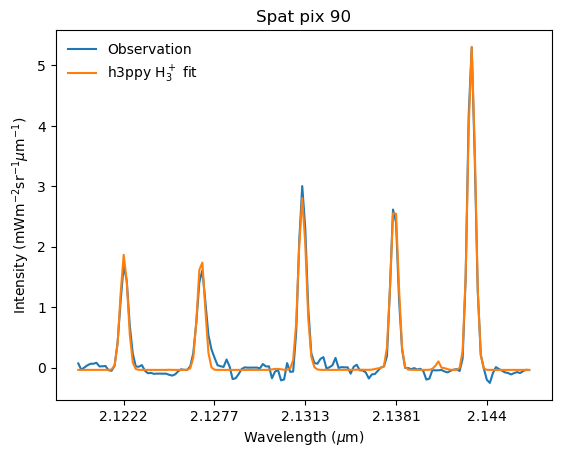

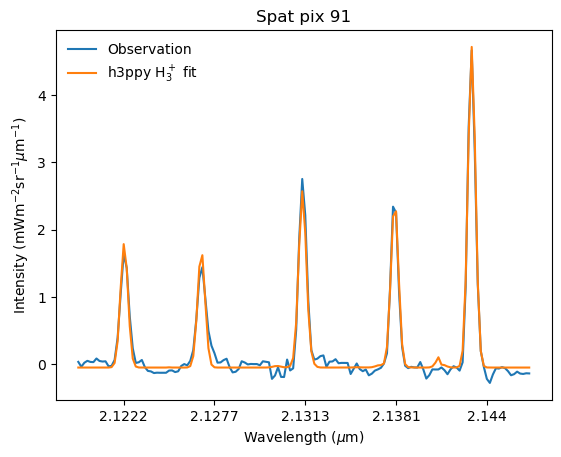

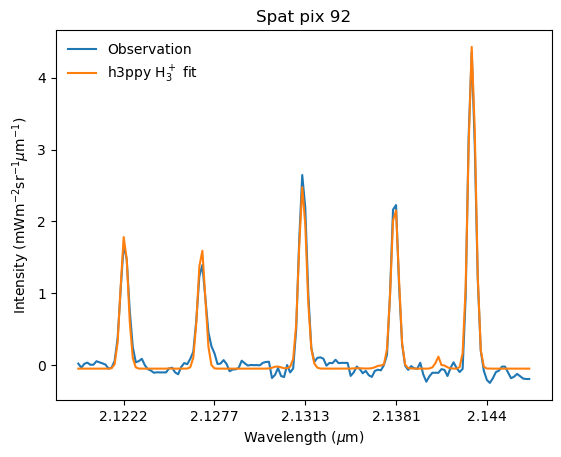

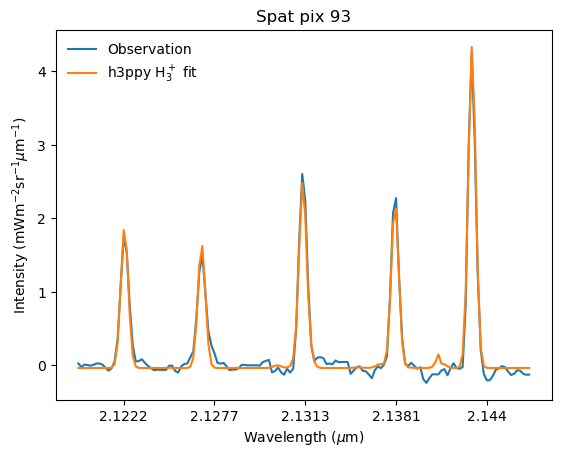

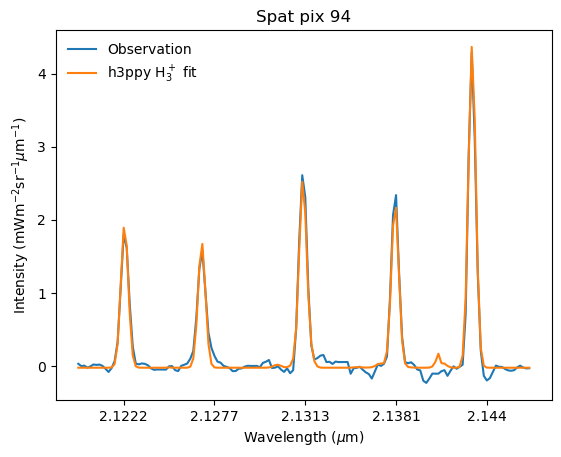

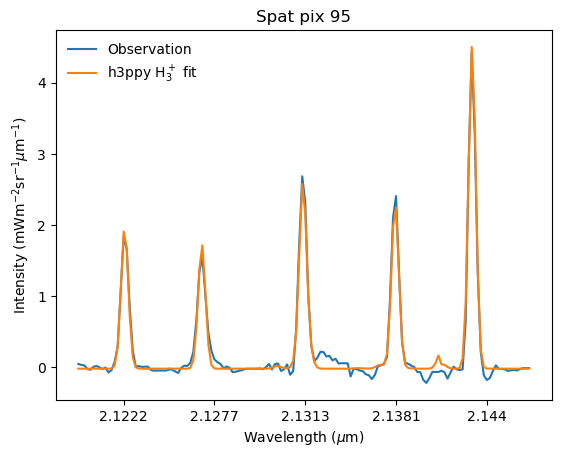

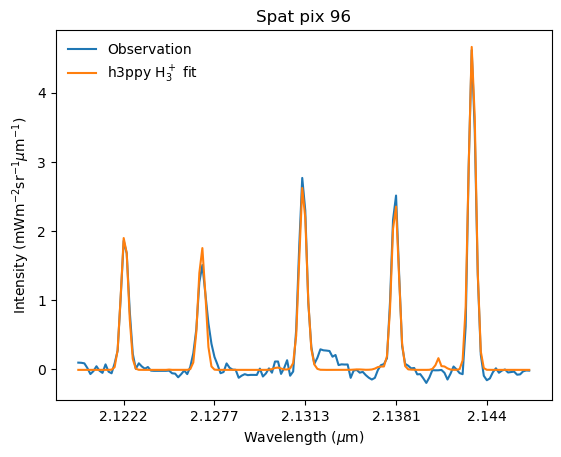

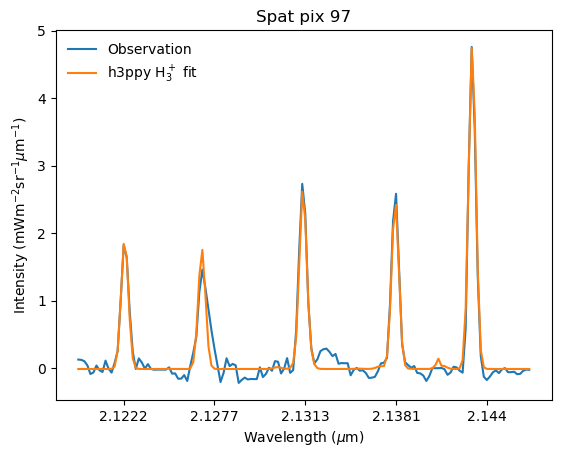

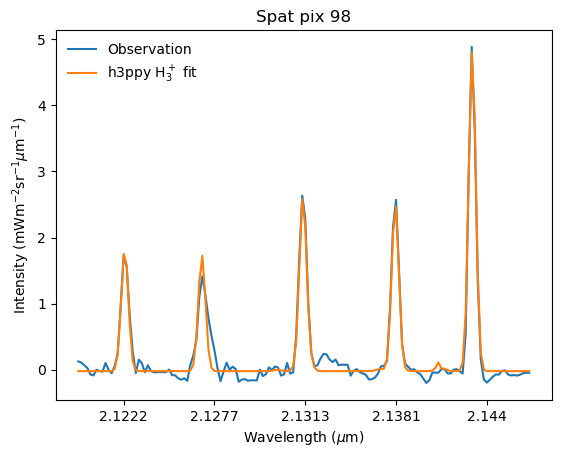

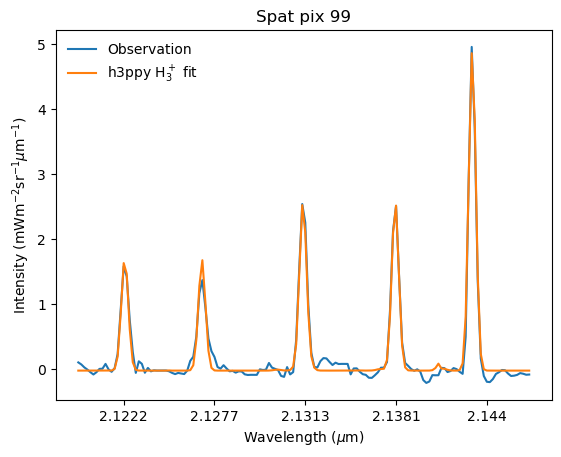

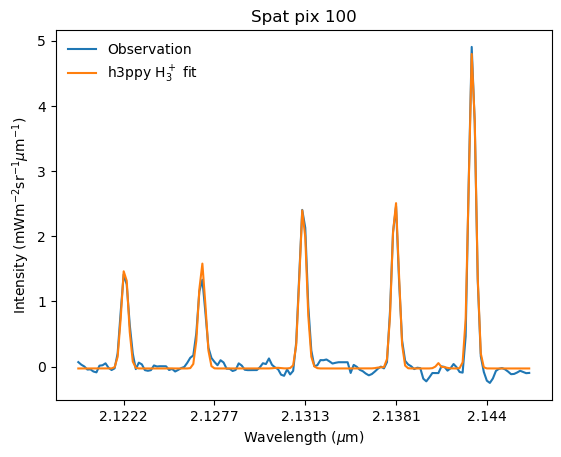

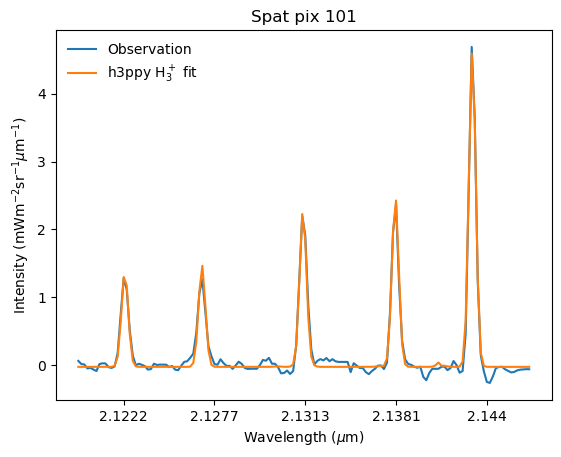

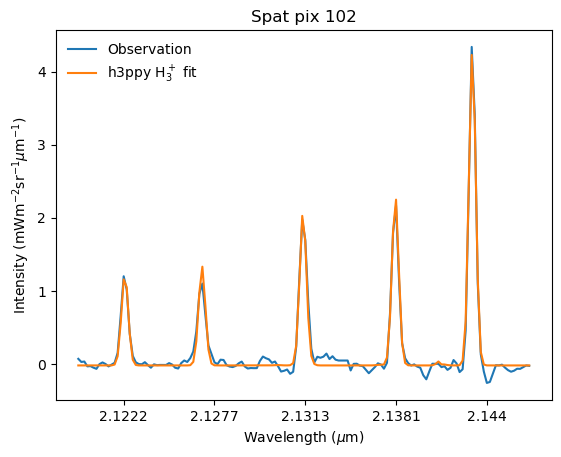

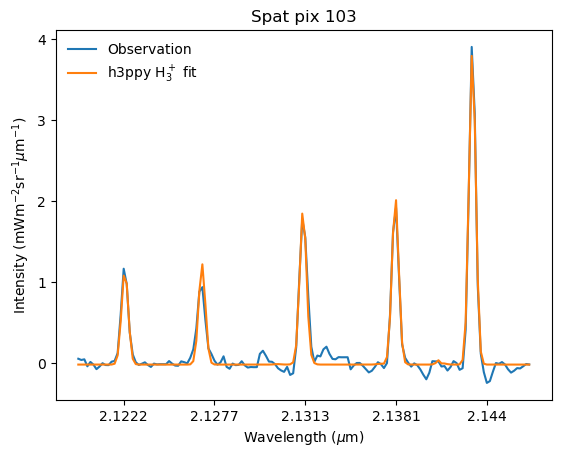

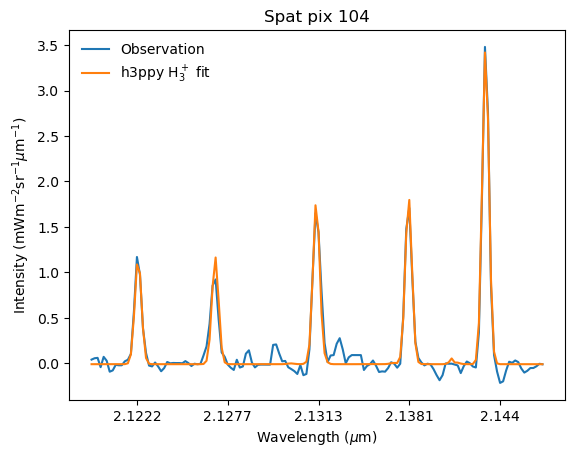

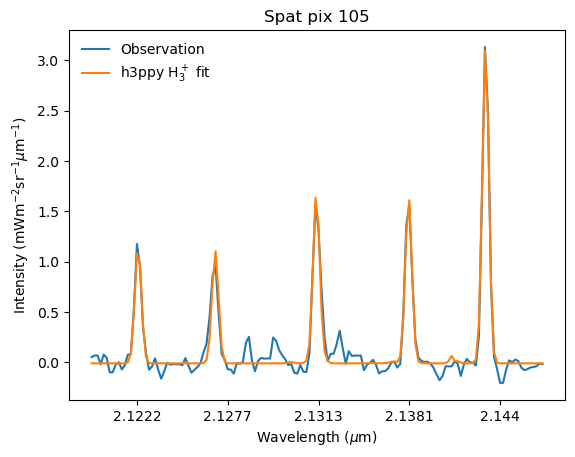

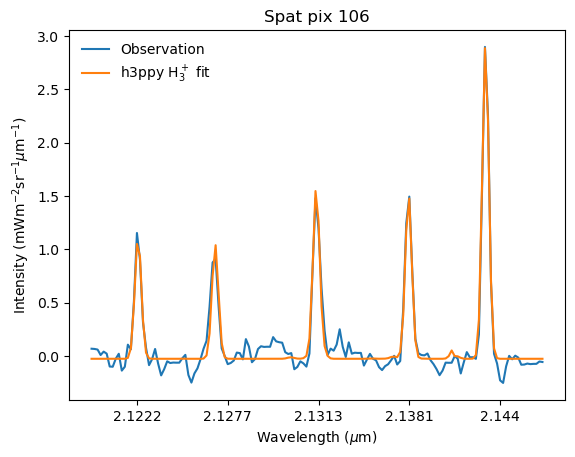

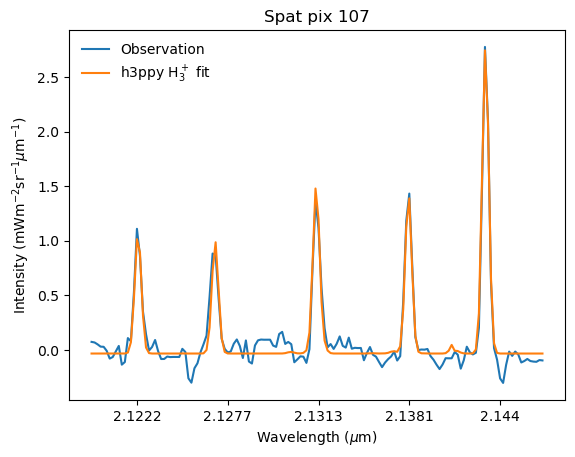

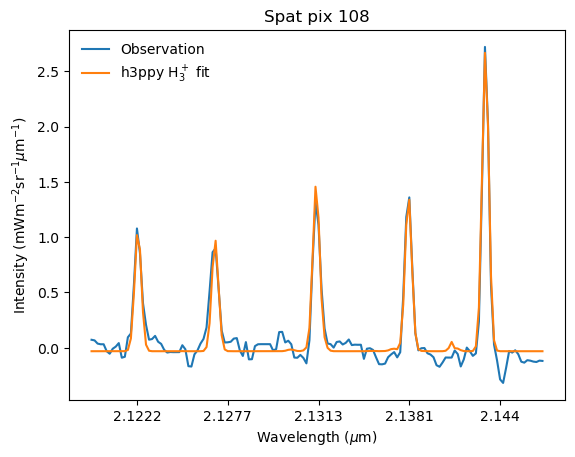

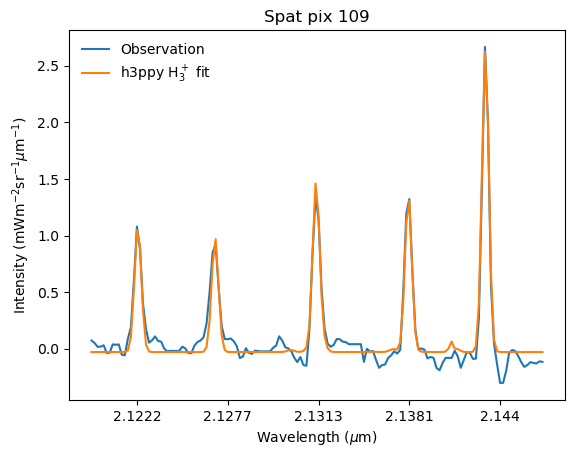

In [60]:
import h3ppy

h3p = h3ppy.h3p()
h2 = h3ppy.h2()

wave = wave36_to_fit

model = h3p.model(density = 4e16, temperature = 1000, R = 25000, wavelength = wave)
model2 = h2.model(density = 3e25, temperature = 1000, R = 25000, wavelength = wave)

centers = [2.1222, 2.1277, 2.1313, 2.1381, 2.144]
cpos = np.arange(5) * 30 + 15

density = []
density_errs = []

temp = []
temp_errs = []

offset_0 = []
sigma_0 = []
background_0 = 0

for i in range(90,110):
    spec = spec36_to_fit[i]
    
    noise = np.median(spec)
    newspec = spec - noise
    
    h3p.set(wavelength = wave, data = newspec, R = 25000, density = 3e16, temperature = 1300)

    xx = range(len(spec))

    fit = h3p.fit(params_to_fit=['density','temperature', 'offset_0', 'sigma_0', 'background_0'])
        
    vars, errs = h3p.get_results(verbose=False)
    
    # Plot the fit
    fig, ax = plt.subplots()
    ax.plot(xx, newspec * 1e3, '-', label = 'Observation')
    ax.plot(xx, fit * 1e3, label = 'h3ppy H$_3^+$ fit')
    ax.set(xlabel = h3p.xlabel(), ylabel = h3p.ylabel(prefix = 'm'), xticks = cpos, title = 'Spat pix '+str(i))
    ax.set_xticklabels(centers)
    ax.legend(frameon = False)
    
    density.append([vars['density']])
    density_errs.append([errs['density']])
    
    temp.append([vars['temperature']])
    temp_errs.append([errs['temperature']])
#     offset_0.append[vars['offset_0']]
#     sigma_0.append[vars['sigma_0']]
#     background_0.append[vars['background_0']]

In [6]:
import h3ppy

# Create the H3+ object
h3p = h3ppy.h3p(line_list_file = 'h3p_line_list_neale_1996_very_detailed.txt')
h2 = h3ppy.h2()

# Define a wavelength range, e.g. typical of an observation of the H3+ Q branch
# Specify the start and end wavelengths, and the number of wavelength elements
# wave = h3p.wavegen(3.94, 4.03, 1024)
wave = waverange36[:1001]
spec = fjc36_rs[1][30:240,:1001][90]

noise = np.median(spec)

spec = spec - noise

# Create a H3+ model spectrum for a set of physical parameters 
# Spectral resolution R = 1200, T = 1000, N = 1e14
# This is the minimum set of parameters required for generating a model
model = h3p.model(density = 1e17, temperature = 950, R = R36/3, wavelength = wave)
model2 = h2.model(density = 3e25, temperature = 950, R = R36/3, wavelength = wave)

newspec = scipy.ndimage.shift(spec, -w_off, order=3, mode='nearest')

# Plot the model
fig, ax = plt.subplots()
ax.plot(wave, model, label = 'H3+ model')
# ax.plot(wave, model2)
ax.plot(wave, spec,'k', lw=0.8, label = 'Observation')
# ax.plot(wave, newspec, label = 'shifted spec')
# ax.set_xlim(wave[0], wave[-1])
# ax.set_xlim(2.1273,2.1279)
# ax.set_xlim(2.130,2.135)
# Automagically set the labels 
ax.set_xlabel(h3p.xlabel())
ax.set_ylabel(h3p.ylabel())
# plt.savefig('example_model.png')
# plt.close() 
ax.legend(frameon = False)

KeyboardInterrupt: 